Classifier Training and Evaluation

Train 5 different classifiers on YAMNet embeddings:
1. Logistic Regression (baseline)
2. Random Forest
3. Gradient Boosting (XGBoost)
4. Support Vector Machine (SVM)
5. Multi-Layer Perceptron (MLP)

Each classifier is evaluated on validation set and saved for later comparison.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, precision_score,
                             recall_score, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

TRAIN_FEATURES_DIR = '../data/approach1/features/train'
VAL_FEATURES_DIR = '../data/approach1/features/val'
TEST_FEATURES_DIR = '../data/approach1/features/test'
MODELS_DIR = '../models/models_approach1'
RESULTS_DIR = '../results/results_approach1'
RANDOM_SEED = 42
N_FOLDS = 3

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
np.random.seed(RANDOM_SEED)

In [2]:
print("LOADING PRE-SPLIT DATA")

# Load training set
X_train = np.load(os.path.join(TRAIN_FEATURES_DIR, 'yamnet_features.npy'))
y_train = np.load(os.path.join(TRAIN_FEATURES_DIR, 'yamnet_labels.npy'))
train_metadata = pd.read_csv(os.path.join(TRAIN_FEATURES_DIR, 'yamnet_features_metadata.csv'))

# Load validation set
X_val = np.load(os.path.join(VAL_FEATURES_DIR, 'yamnet_features.npy'))
y_val = np.load(os.path.join(VAL_FEATURES_DIR, 'yamnet_labels.npy'))
val_metadata = pd.read_csv(os.path.join(VAL_FEATURES_DIR, 'yamnet_features_metadata.csv'))

print(f"\nTraining set: {X_train.shape[0]:,} samples")
print(f"Validation set: {X_val.shape[0]:,} samples")
print(f"Feature dim: {X_train.shape[1]}")

LOADING PRE-SPLIT DATA

Training set: 5,082 samples
Validation set: 714 samples
Feature dim: 1024


In [3]:
# ==================== ENCODE LABELS ====================
# Fit label encoder on training data
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

classes = label_encoder.classes_
print(f"\nClasses ({len(classes)}): {', '.join(classes)}")

# Display class distribution
print(f"\n{'Split':<12} {'Category':<20} {'Count':<10} {'Percentage':<10}")
print("-"*60)
for split_name, y_split in [('Train', y_train_encoded), ('Val', y_val_encoded)]:
    for idx, cls in enumerate(classes):
        count = np.sum(y_split == idx)
        percentage = count / len(y_split) * 100
        print(f"{split_name:<12} {cls:<20} {count:<10} {percentage:>6.2f}%")
    print("-"*60)


Classes (5): Alarm_Clock, Car_Horn, Glass_Breaking, Gunshot, Siren

Split        Category             Count      Percentage
------------------------------------------------------------
Train        Alarm_Clock          918         18.06%
Train        Car_Horn             1032        20.31%
Train        Glass_Breaking       960         18.89%
Train        Gunshot              1068        21.02%
Train        Siren                1104        21.72%
------------------------------------------------------------
Val          Alarm_Clock          132         18.49%
Val          Car_Horn             156         21.85%
Val          Glass_Breaking       112         15.69%
Val          Gunshot              158         22.13%
Val          Siren                156         21.85%
------------------------------------------------------------


In [4]:
# ==================== SCALE FEATURES ====================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Save scaler and encoder
joblib.dump(scaler, os.path.join(MODELS_DIR, 'feature_scaler.pkl'))
joblib.dump(label_encoder, os.path.join(MODELS_DIR, 'label_encoder.pkl'))
print(f"\nSaved scaler and label encoder to: {MODELS_DIR}")


Saved scaler and label encoder to: ../models/models_approach1


In [5]:
# DEFINE CLASSIFIERS AND HYPERPARAMETERS
classifiers = {
    'Logistic_Regression': {
        'model': LogisticRegression(random_state=RANDOM_SEED, max_iter=1000, n_jobs=-1),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        },
        'scaled': True
    },
    'Random_Forest': {
        'model': RandomForestClassifier(random_state=RANDOM_SEED, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt']
        },
        'scaled': False
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(
            random_state=RANDOM_SEED,
            n_jobs=-1,
            objective='multi:softprob',
            eval_metric='mlogloss'
        ),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        },
        'scaled': False
    },
    'SVM': {
        'model': SVC(random_state=RANDOM_SEED, probability=True, cache_size=1000),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['rbf'],
            'gamma': ['scale', 'auto']
        },
        'scaled': True
    },
    'MLP': {
        'model': MLPClassifier(
            random_state=RANDOM_SEED,
            max_iter=500,
            early_stopping=True,
            n_iter_no_change=15
        ),
        'params': {
            'hidden_layer_sizes': [(256,), (512,), (256, 128)],
            'activation': ['relu'],
            'alpha': [0.0001, 0.001],
            'learning_rate': ['adaptive']
        },
        'scaled': True
    }
}

print("\nClassifiers to train:")
for idx, name in enumerate(classifiers.keys(), 1):
    config = classifiers[name]
    n_combinations = np.prod([len(v) for v in config['params'].values()])
    print(f"{idx}. {name:<25} {n_combinations:>3} hyperparameter combinations")




Classifiers to train:
1. Logistic_Regression         5 hyperparameter combinations
2. Random_Forest              16 hyperparameter combinations
3. XGBoost                    72 hyperparameter combinations
4. SVM                         6 hyperparameter combinations
5. MLP                         6 hyperparameter combinations


In [6]:
print("TRAINING CLASSIFIERS")

results = {}
best_models = {}

for name, config in classifiers.items():
    print(f"\n{'='*80}")
    print(f"Training: {name}")
    print(f"{'='*80}")

    # Use scaled or unscaled features based on model requirements
    X_tr = X_train_scaled if config['scaled'] else X_train
    X_va = X_val_scaled if config['scaled'] else X_val

    # Grid search with cross-validation on training set
    grid = GridSearchCV(
        config['model'],
        config['params'],
        cv=StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED),
        scoring='f1_macro',
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_tr, y_train_encoded)

    # Get best model
    model = grid.best_estimator_
    best_models[name] = model

    # Validation predictions
    y_val_pred = model.predict(X_va)
    y_val_proba = model.predict_proba(X_va)

    # Calculate validation metrics
    val_metrics = {
        'accuracy': accuracy_score(y_val_encoded, y_val_pred),
        'precision': precision_score(y_val_encoded, y_val_pred, average='macro'),
        'recall': recall_score(y_val_encoded, y_val_pred, average='macro'),
        'f1_macro': f1_score(y_val_encoded, y_val_pred, average='macro'),
        'f1_weighted': f1_score(y_val_encoded, y_val_pred, average='weighted')
    }

    results[name] = {
        'best_params': grid.best_params_,
        'cv_f1': grid.best_score_,
        'val_metrics': val_metrics,
        'val_pred': y_val_pred,
        'val_proba': y_val_proba
    }

    print(f"\nBest Parameters: {grid.best_params_}")
    print(f"CV F1 (macro): {grid.best_score_:.4f}")
    print(f"Validation Metrics:")
    print(f"  Accuracy: {val_metrics['accuracy']:.4f}")
    print(f"  Precision: {val_metrics['precision']:.4f}")
    print(f"  Recall: {val_metrics['recall']:.4f}")
    print(f"  F1 (macro): {val_metrics['f1_macro']:.4f}")

    # Save model
    model_path = os.path.join(MODELS_DIR, f'{name.lower()}_model.pkl')
    joblib.dump(model, model_path)
    print(f"\nModel saved to: {model_path}")



TRAINING CLASSIFIERS

Training: Logistic_Regression
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
CV F1 (macro): 0.9156
Validation Metrics:
  Accuracy: 0.8725
  Precision: 0.8728
  Recall: 0.8731
  F1 (macro): 0.8721

Model saved to: ../models/models_approach1\logistic_regression_model.pkl

Training: Random_Forest
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best Parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
CV F1 (macro): 0.9110
Validation Metrics:
  Accuracy: 0.8866
  Precision: 0.8860
  Recall: 0.8873
  F1 (macro): 0.8855

Model saved to: ../models/models_approach1\random_forest_model.pkl

Training: XGBoost
Fitting 3 folds for each of 72 candidates, totalling 216 fits

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
CV F1 (macro): 0.9206
Vali


MODEL COMPARISON (Validation F1)


              Model  CV F1  Val Acc  Val F1  Val Precision  Val Recall
      Random_Forest 0.9110   0.8866  0.8855         0.8860      0.8873
            XGBoost 0.9206   0.8754  0.8745         0.8762      0.8747
Logistic_Regression 0.9156   0.8725  0.8721         0.8728      0.8731
                MLP 0.9194   0.8683  0.8688         0.8682      0.8729
                SVM 0.9128   0.8333  0.8350         0.8381      0.8341

Saved comparison: ../results/results_approach1\model_comparison.csv
Saved validation confusion matrices: ../results/results_approach1\val_confusion_matrices.png


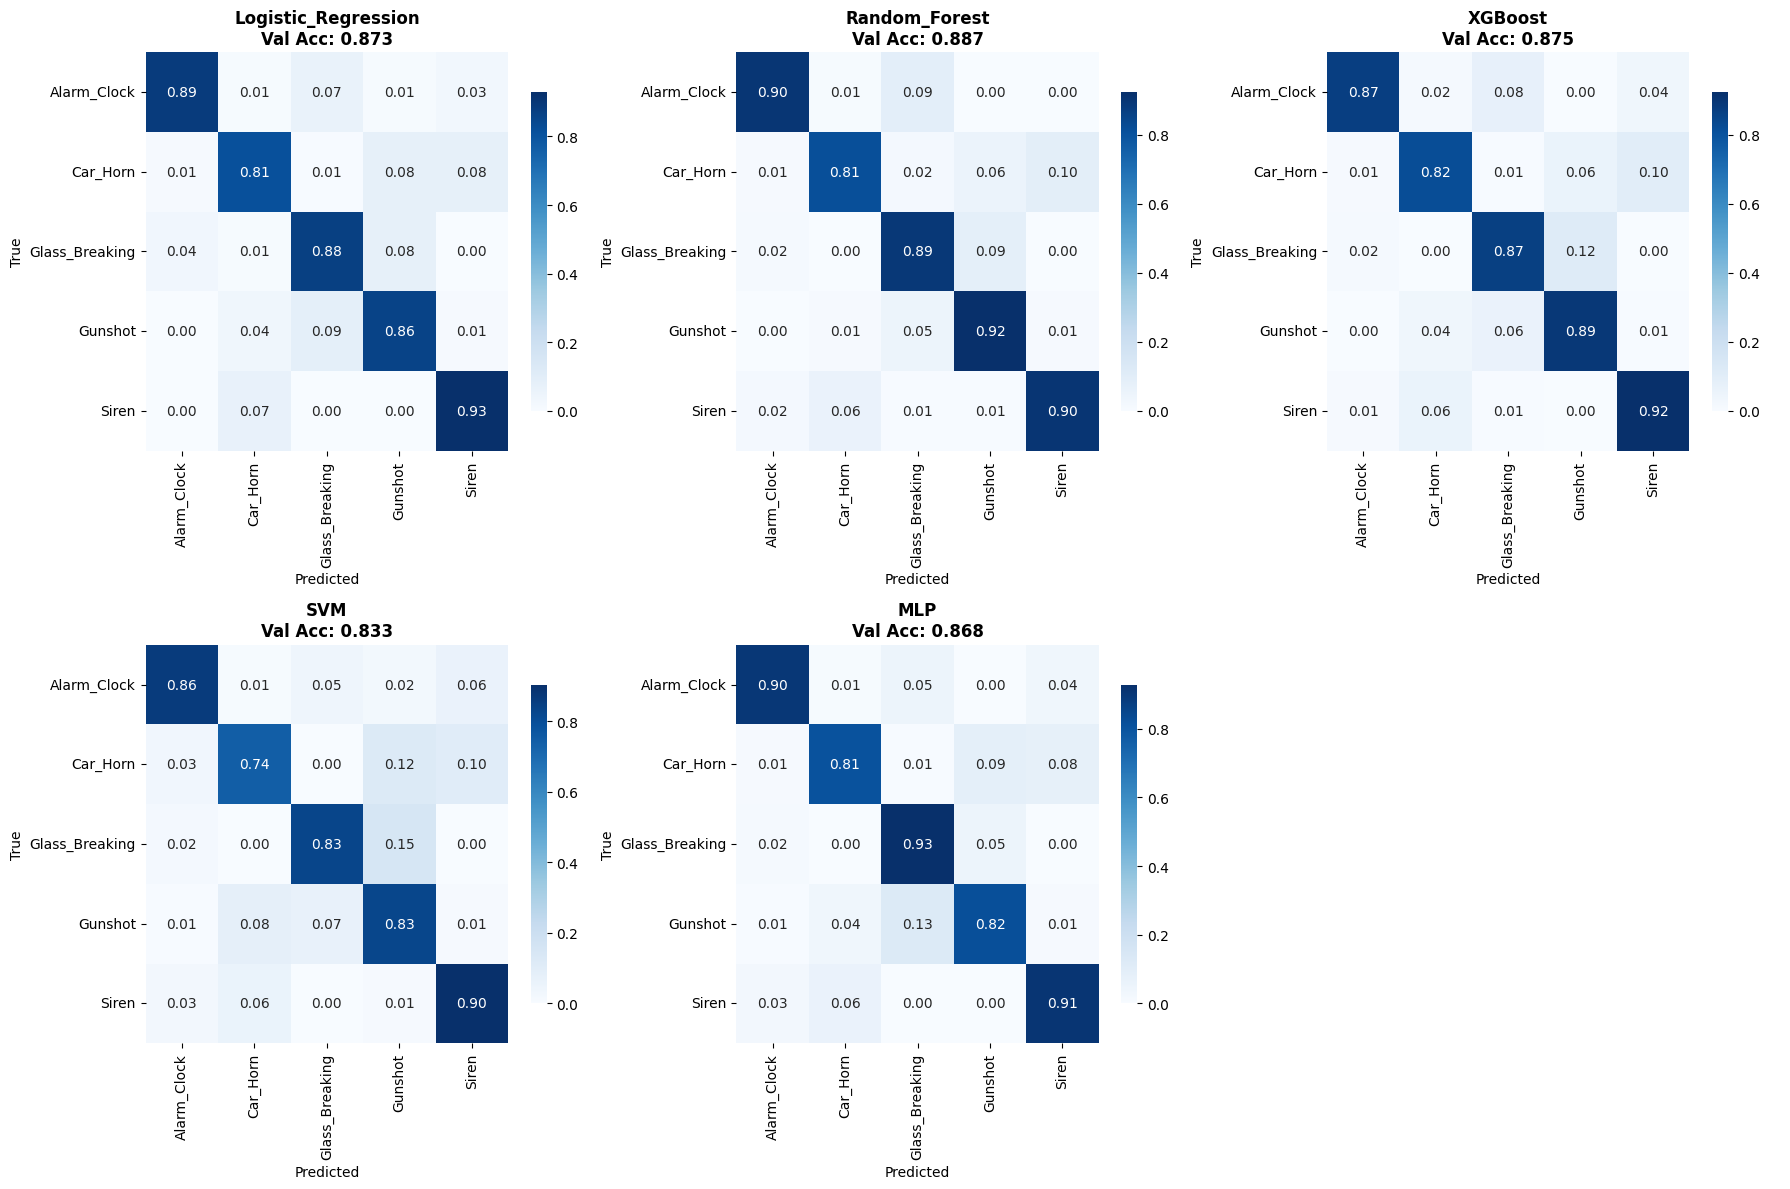

In [7]:
print("\nMODEL COMPARISON (Validation F1)\n")

comparison = []
for name, r in results.items():
    comparison.append({
        'Model': name,
        'CV F1': round(r['cv_f1'], 4),
        'Val Acc': round(r['val_metrics']['accuracy'], 4),
        'Val F1': round(r['val_metrics']['f1_macro'], 4),
        'Val Precision': round(r['val_metrics']['precision'], 4),
        'Val Recall': round(r['val_metrics']['recall'], 4)
    })

comp_df = pd.DataFrame(comparison).sort_values('Val F1', ascending=False)
print("\n" + comp_df.to_string(index=False))

comp_path = os.path.join(RESULTS_DIR, 'model_comparison.csv')
comp_df.to_csv(comp_path, index=False)
print(f"\nSaved comparison: {comp_path}")

# CONFUSION MATRIX (Validation Only)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (name, r) in enumerate(results.items()):
    cm = confusion_matrix(y_val_encoded, r['val_pred'])  # FIXED HERE: Use r['val_pred'] instead of y_val_pred_encoded
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes, ax=axes[idx],
                cbar_kws={'shrink': 0.8})
    acc = r['val_metrics']['accuracy']
    axes[idx].set_title(f'{name}\nVal Acc: {acc:.3f}', fontweight='bold')
    axes[idx].set_ylabel('True')
    axes[idx].set_xlabel('Predicted')

if len(results) < 6:
    for j in range(len(results), 6):
        axes[j].axis('off')

plt.tight_layout()
cm_path = os.path.join(RESULTS_DIR, 'val_confusion_matrices.png')
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
print(f"Saved validation confusion matrices: {cm_path}")
plt.show()



In [8]:
# FINAL SUMMARY
print("\nTRAINING COMPLETE (Test Set Untouched)")

best = comp_df.iloc[0]
print(f"  Best Model: {best['Model']}")
print(f"  Validation F1: {best['Val F1']}")
print(f"  All models saved: {MODELS_DIR}")
print(f"  Test set preserved for final comparison")


TRAINING COMPLETE (Test Set Untouched)
  Best Model: Random_Forest
  Validation F1: 0.8855
  All models saved: ../models/models_approach1
  Test set preserved for final comparison
